# Caricamento del DataSet

Il dataset si trova a questo link: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#

In [1]:
# Import dei pacchetti che mi servono nell'analisi
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, decomposition

In [2]:
%%time

# Caricamento del dataset come dataframe di Pandas
dati_originali = pd.read_csv("dataSet/diabetic_data.csv")

# Creo una copia del DS che analizzerò e cambierò
dati = dati_originali.copy()

print("Il dataset è composto da", dati.shape[0], "eventi e", dati.shape[1], "features")
dati.head(5)

Il dataset è composto da 101766 eventi e 50 features
Wall time: 1.32 s


encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

---

---

# Data Exploration

In questa parte esploro il DataSet appena caricato, studiando come si distribuiscono le varie features, individuando eventuali dati patologici e correggendoli

### Possibili outcome della misura

Come prima analisi verifico che ci siano 3 possibili classi (come indicato nell'articolo di riferimento) e passo da un problema a 3 classi a 2

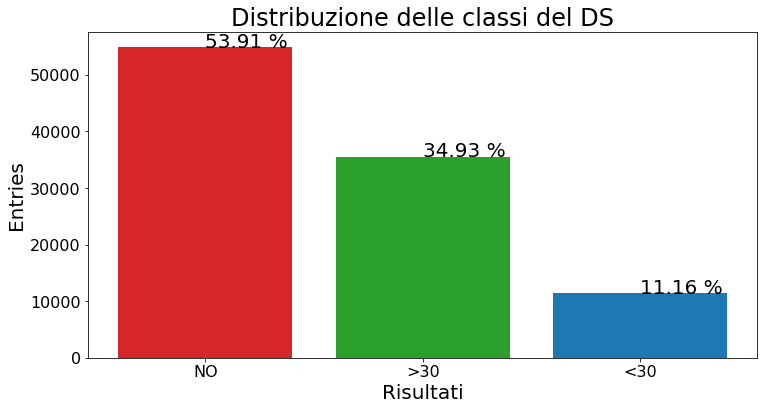

In [3]:
# Plot delle classi
fig, ax = plt.subplots(figsize = (12,6))
plt.title(f"Distribuzione delle classi del DS", size = 24)

ax.bar( dati["readmitted"].value_counts().index, height = dati["readmitted"].value_counts(), color = ["tab:red", "tab:green", "tab:blue"])

testo0 = dati["readmitted"].value_counts()[0] / dati["readmitted"].shape[0] * 100
ax.annotate( f"{testo0:.2f} %", (dati["readmitted"].value_counts().index[0], dati["readmitted"].value_counts()[0]) , fontsize = 20)

testo1 = dati["readmitted"].value_counts()[1] / dati["readmitted"].shape[0] * 100
ax.annotate( f"{testo1:.2f} %", (dati["readmitted"].value_counts().index[1], dati["readmitted"].value_counts()[1]) , fontsize = 20)

testo2 = dati["readmitted"].value_counts()[2] / dati["readmitted"].shape[0] * 100
ax.annotate( f"{testo2:.2f} %", (dati["readmitted"].value_counts().index[2], dati["readmitted"].value_counts()[2]) , fontsize = 20)

plt.xlabel("Risultati", fontsize = 20)
plt.ylabel("Entries", fontsize = 20)
ax.tick_params(labelsize = 16)
plt.show()

Noto che ho 3 possibili classi:
* "NO" cioè il paziente non si è rimesso dopo le cure
* ">30" cioè il paziente si è rimesso dopo 30 giorni dalle dimissioni dall'ospedale
* "<30" cioè il paziente si è rimesso prima di 30 giorni dalle dimissioni dall'ospedale

A questo punto quindi passo da 3 classi a 2:
* il paziente non si è rimesso "No", mantenendo i dati "NO"
* il paziente si è rimesso "Yes", unendo i dati "<30" e ">30"

Cercherò quindi di predire se il paziente si è rimesso oppure no, considero se il paziente si è rimesso in più o meno di 30 giorni come un unico caso

In [4]:
# Creo una nuova feature che ha solo due classi: No = "NO" e Yes = "<30" e ">30"
def cambio_classi(text):
    if text == '>30' or text =='<30':
        return 'Yes'
    else:
        return 'No'

dati["readmitted_2"] = dati["readmitted"].apply(cambio_classi) 

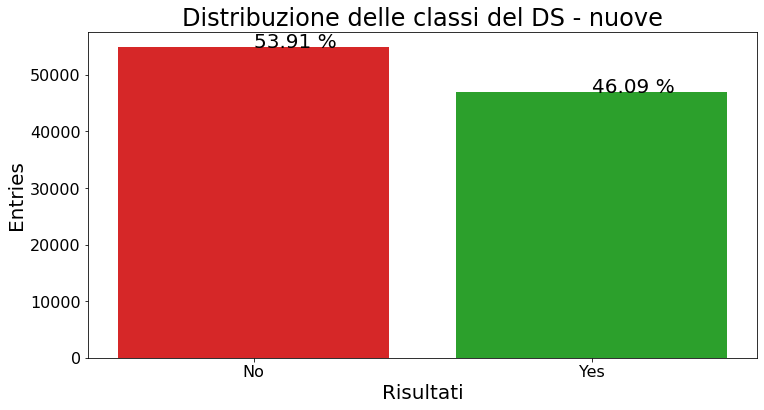

In [5]:
# Plot dei risultati
fig, ax = plt.subplots(figsize = (12,6))
plt.title(f"Distribuzione delle classi del DS - nuove", size = 24)

ax.bar( dati["readmitted_2"].value_counts().index, height = dati["readmitted_2"].value_counts(), color = ["tab:red", "tab:green"])

testo0 = dati["readmitted_2"].value_counts()[0] / dati["readmitted_2"].shape[0] * 100
ax.annotate( f"{testo0:.2f} %", (dati["readmitted_2"].value_counts().index[0], dati["readmitted_2"].value_counts()[0]) , fontsize = 20)

testo1 = dati["readmitted_2"].value_counts()[1] / dati["readmitted_2"].shape[0] * 100
ax.annotate( f"{testo1:.2f} %", (dati["readmitted_2"].value_counts().index[1], dati["readmitted_2"].value_counts()[1]) , fontsize = 20)

plt.xlabel("Risultati", fontsize = 20)
plt.ylabel("Entries", fontsize = 20)
ax.tick_params(labelsize = 16)
plt.show()

Noto che il DataSet è abbastanza bilanciato, cioè le due classi sono distribuite egualmente nel DS. Ognuna rappresenta circa il 50% dei dati e questo sarà molto utile per non creare sbilanciamenti nella fase di Training

Infine elimino la feature "readmitted" visto che userò solamente la nuova feature "readmitted_2" come valore vero

In [6]:
# Eliminazione della feature "readmitted"
dati.drop(columns = ["readmitted"], inplace = True)

---

### Distribuzione delle classi all'interno del dataset

Vado ora a studiare come si distribuiscono le classi all'interno del DS per verificare che siano distribuiti in modo uniforme, altrimenti sarà necessario fare un reshuffle dei dati prima di dividere il DS in Training Set e Test Set

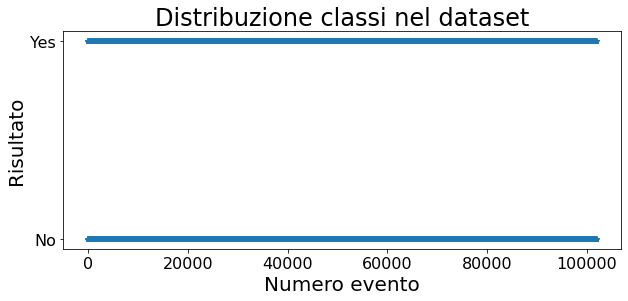

In [7]:
# Plot dei risultati
fig, ax = plt.subplots(figsize = (10,4))
plt.title(f"Distribuzione classi nel dataset", size = 24)

ax.plot(dati["readmitted_2"], "*", c = "tab:blue")

plt.xlabel("Numero evento", fontsize = 20)
plt.ylabel("Risultato", fontsize = 20)
ax.tick_params(labelsize = 16)
plt.show()

Noto che non vi è una netta separazione tra le due classi (per esempio prima tutti Yes e poi tutti No), ma che sono distribuite in modo uniforme all'interno del DS e quindi non sarà necessario applicare un rimescolamento dei dati prima di dividere il DS in TrS e TeS

---

### Distribuzioni delle features
Inizio a studiare la distribuzione statistica di tutte le features presenti

In [8]:
# Stampo delle informazioni generali relative alle features che abbiamo nel DS
dati.describe(include = 'all').T

count unique        top    freq  \
encounter_id              101766.0    NaN        NaN     NaN   
patient_nbr               101766.0    NaN        NaN     NaN   
race                        101766      6  Caucasian   76099   
gender                      101766      3     Female   54708   
age                         101766     10    [70-80)   26068   
weight                      101766     10          ?   98569   
admission_type_id         101766.0    NaN        NaN     NaN   
discharge_disposition_id  101766.0    NaN        NaN     NaN   
admission_source_id       101766.0    NaN        NaN     NaN   
time_in_hospital          101766.0    NaN        NaN     NaN   
payer_code                  101766     18          ?   40256   
medical_specialty           101766     73          ?   49949   
num_lab_procedures        101766.0    NaN        NaN     NaN   
num_procedures            101766.0    NaN        NaN     NaN   
num_medications           101766.0    NaN        NaN     NaN   
number_outpatient         101766.0    NaN        NaN     NaN   
number_emergency          101766.0    NaN        NaN     NaN   
number_inpatient          101766.0    NaN        NaN     NaN   
diag_1                      101766    717        428    6862   
diag_2                      101766    749        276    6752   
diag_3                      101766    790        250   11555   
number_diagnoses          101766.0    NaN        NaN     NaN   
max_glu_serum               101766      4       None   96420   
A1Cresult                   101766      4       None   84748   
metformin                   101766      4         No   81778   
repaglinide                 101766      4         No  100227   
nateglinide                 101766      4         No  101063   
chlorpropamide              101766      4         No  101680   
glimepiride                 101766      4         No   96575   
acetohexamide               101766      2         No  101765   
glipizide                   101766      4         No   89080   
glyburide                   101766      4         No   91116   
tolbutamide                 101766      2         No  101743   
pioglitazone                101766      4         No   94438   
rosiglitazone               101766      4         No   95401   
acarbose                    101766      4         No  101458   
miglitol                    101766      4         No  101728   
troglitazone                101766      2         No  101763   
tolazamide                  101766      3         No  101727   
examide                     101766      1         No  101766   
citoglipton                 101766      1         No  101766   
insulin                     101766      4         No   47383   
glyburide-metformin         101766      4         No  101060   
glipizide-metformin         101766      2         No  101753   
glimepiride-pioglitazone    101766      2         No  101765   
metformin-rosiglitazone     101766      2         No  101764   
metformin-pioglitazone      101766      2         No  101765   
change                      101766      2         No   54755   
diabetesMed                 101766      2        Yes   78363   
readmitted_2                101766      2         No   54864   

                                      mean               std      min  \
encounter_id              165201645.622978  102640295.983458  12522.0   
patient_nbr                54330400.694947   38696359.346534    135.0   
race                                   NaN               NaN      NaN   
gender                                 NaN               NaN      NaN   
age                                    NaN               NaN      NaN   
weight                                 NaN               NaN      NaN   
admission_type_id                 2.024006          1.445403      1.0   
discharge_disposition_id          3.715642          5.280166      1.0   
admission_source_id               5.754437          4.064081      1.0   
time_in_hospital                  

In [9]:
# Cerco se ci sono delle features senza valore cioè con "?" oppure con "NaN"
for i in dati.columns:
    print( i.ljust(25), "\t", dati[dati[i] == '?'].shape[0], "\t\t", dati[dati[i] == np.nan].shape[0] )


encounter_id              	 0 		 0
patient_nbr               	 0 		 0
race                      	 2273 		 0
gender                    	 0 		 0
age                       	 0 		 0
weight                    	 98569 		 0
admission_type_id         	 0 		 0
discharge_disposition_id  	 0 		 0
admission_source_id       	 0 		 0
time_in_hospital          	 0 		 0
payer_code                	 40256 		 0
medical_specialty         	 49949 		 0
num_lab_procedures        	 0 		 0
num_procedures            	 0 		 0
num_medications           	 0 		 0
number_outpatient         	 0 		 0
number_emergency          	 0 		 0
number_inpatient          	 0 		 0
diag_1                    	 21 		 0
diag_2                    	 358 		 0
diag_3                    	 1423 		 0
number_diagnoses          	 0 		 0
max_glu_serum             	 0 		 0
A1Cresult                 	 0 		 0
metformin                 	 0 		 0
repaglinide               	 0 		 0
nateglinide               	 0 		 0
chlorpropamide            	 0 		 0

Osservo che ci sono molti valori nulli "?" nelle features "race", "weight", "payer_code", "medical_specialty", "diag_1", "diag_2" e "diag_3" e che non ci sono valori "NaN"

Analizzo meglio questi casi patologici e cerco di correggerli

## Correzione casi patologici

### Race

In [10]:
# Plot della features "race"
fig, ax = plt.subplots(figsize = (10,6))
plt.title(f"Distribuzione della provenienza dei pazienti", size = 24)
          
ax.bar( dati["race"].value_counts().index, height = dati["race"].value_counts(), color = ["tab:blue", "tab:green", "tab:red", "tab:gray","tab:cyan","tab:purple"])
plt.xlabel("Race", size = 14)
plt.xticks(rotation = 30, size = 12)
plt.ylabel("Entries", size = 14)
ax.tick_params(labelsize = 12)
plt.show()

Posso notare che la maggior parte dei pazienti ha origini Caucasiche

Inoltre, quando non è specificata la provenienza vi è "?" che quindi sono i nostri casi da cambiare. Lo facciamo mettendo tutti i casi "?" nella categoria "Other" già esistente

In [11]:
# Assegno al posto di "?" la categoria "Other"
dati.loc[ dati["race"] == "?", "race"] = "Other"

In [12]:
# Plot della features "race", cambiata
fig, ax = plt.subplots(figsize = (10,6))
plt.title(f"Distribuzione della provenienza dei pazienti - corretta", size = 20)
          
ax.bar( dati["race"].value_counts().index, height = dati["race"].value_counts(), color = ["tab:blue", "tab:green", "tab:red", "tab:gray","tab:cyan"])
plt.xlabel("Race", size = 14)
plt.xticks(rotation = 30, size = 12)
plt.ylabel("Entries", size = 14)
ax.tick_params(labelsize = 12)
plt.show()

---

### Weight

Osservo che i valori patologici della features "weight" sono 98569 su un totale di 101000, cioè il 97.59% dei dati

Per questa ragione decido di eliminare questa features perchè potrebbe causare dei problemi nella fase di Training dell'algoritmo di Machine Learning

In [13]:
# Visualizzo i vari outcome della feature
dati["weight"].value_counts()

?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

In [14]:
# Eliminazione della feature "weight"
dati.drop(columns = ["weight"], inplace = True)

---

### Payer_code

Dalla letteratura (https://www.nhhealthyfamilies.com/newsroom/payer-id-tip-sheet.html), il Payer code è "a unique ID number that is assigned to an insurance company for the purpose of transmitting provider claims electronically. Each company has a specific number that must be used in order to achieve proper adjudication of the claim"

Noto che ci sono 40256 elementi nulli su 101000, cioè il 39.86% del totale

Visto che rappresentano una buona parte dei dati, non elimino gli eventi nulli (eliminando quindi più di un terzo degli eventi), ma elimino direttamentene questa features dal DS perchè potrebbe creare problemi nella fase di Training

In [15]:
# Visualizzo i vari outcome della feature
dati["payer_code"].value_counts()

?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64

In [16]:
# Eliminazione della feature "payer_code"
dati.drop(columns = ['payer_code'], inplace = True)

---

### Medical_specialty

Questa features rappresenta le varie specializzazioni del medico curante come: chirurgia, cardiologia, pediatria...

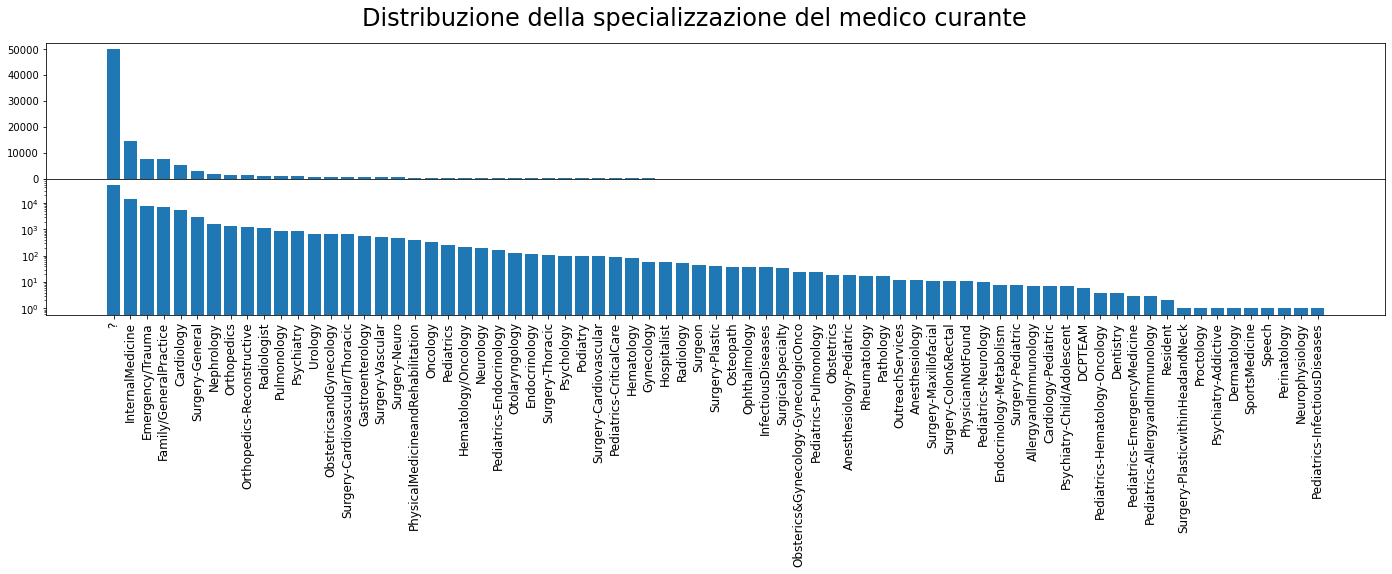

In [17]:
# Plot della features "medical_specialty"
fig, ax = plt.subplots( 2, 1, figsize = (24,5), sharex = True)
plt.suptitle(f"Distribuzione della specializzazione del medico curante", size = 24)
fig.subplots_adjust(hspace = 0)

# Primo plot in scala lineare
ax[0].bar( dati["medical_specialty"].value_counts().index, height = dati['medical_specialty'].value_counts())

# Secondo plot in scala logaritmica
ax[1].bar( dati["medical_specialty"].value_counts().index, height = dati['medical_specialty'].value_counts())
ax[1].set_yscale("log")
ax[1].tick_params(labelsize = 10)

plt.xticks(rotation = 90, size = 12)
plt.show()

Osservando il grafico osservo che i valori "?" sono la maggior parte (~50%) e quindi come per i casi precedenti decido di eliminare la feature perchè non porterebbe informazioni aggiuntive e rischierebbe solamente di creare problemi al DS

In [18]:
# Eliminazione della feature "medical_specialty"
dati.drop(columns = ["medical_specialty"], inplace = True)

---

### Diag_1, Diag_2 e Diag_3

Le tre features contengono il codice associato ad ogni paziente. Ogni volta che un paziente viene ammesso in ospedale gli viene dato un codice relativo alla problematica per la quale si è rivolto all'ospedale. (https://www.salute.gov.it/portale/temi/p2_6.jsp?id=1278&area=ricoveriOspedalieri&menu=cl)

* diag_1: "Diagnosis 1", prima diagnosi che viene fatta al paziente appena arriva all'ospedale ed è codificato con 3 cifre del codice ICD-9; sono 848 valori distinti
* diag_2: "Diagnosis 2", seconda diagnosi ed è codificato come per il precedente; sono 923 valori distinti
* diag_3: "Diagnosis 3", ulteriore diagnosi ed è codificato come per il precedente; sono 954 valori distinti

Visto che i valori nulli sono pochi rispetto al totale, eliminiamo questi eventi mantenendo però tutte e 3 le features, cioè eliminiamo circa 1500 eventi

In [19]:
print( (dati["diag_1"] == "?").sum() )
print( (dati["diag_2"] == "?").sum() )
print( (dati["diag_3"] == "?").sum() )

21
358
1423


In [20]:
# Tolgo i valori che corrispondono ai "?" facendo l'OR delle 3 condizioni
dati = dati[ ~( (dati["diag_1"] == "?") | (dati["diag_2"] == "?") | (dati["diag_3"] == "?") ) ]
dati.shape

(100244, 47)

---

## Verifica delle features rimanenti

### Plotto tutte e 47 le features

In [29]:
%%time

# Creo le 47 figure come subplot
fig = plt.figure(figsize = (25,50))
gs = gridspec.GridSpec(nrows = 10, ncols = 10, hspace = .3, wspace = .3)

ax = []
for r in range(9):
    for c in range(5):
        ax.append( fig.add_subplot(gs[r, (2*c):(2*c+2)]) )

ax.append( fig.add_subplot(gs[9, 3:5]) )
ax.append( fig.add_subplot(gs[9, 5:7]) )


# Plotto le 47 features
for graf,i in enumerate( dati.columns ):
    ax[graf].set_title(f"Feature: {i}", fontsize = 16)
    
    if  dati.dtypes[i] == np.int64:
        h, bins = np.histogram(dati[i], bins = 20)
        binc = bins[:-1] + (bins[1] - bins[0])/2
        ax[graf].plot(binc, h, ds = "steps-mid", c = "tab:cyan")
    else:
        ax[graf].bar( dati[i].value_counts().index, height = dati[i].value_counts(), color = "tab:cyan")
    
    ax[graf].set_yscale("log")


fig.savefig("../Esame_relazione/FIGURE/dataset/altre_features.pdf", format = "pdf", bbox_inches = "tight")

plt.show()

Wall time: 57.1 s


---

### Encounter_id & Patient_nbr

Queste due feature rappresentano rispettivamente un codice associato ad ogni ricovero e un codice associato ad ogni paziente (un paziente può essere ricoverato più volte)

Visto che queste due features non hanno alcun significato medico e non portano informazioni aggiuntive nell'analisi, le elimino

In [21]:
# Eliminazione della feature "encounter_id"
dati.drop(columns = ["encounter_id"], inplace = True)
# Eliminazione della feature "patient_nbr"
dati.drop(columns = ["patient_nbr"], inplace = True)

---

### Gender

Posso notare che la feature "Gender" ha 3 possibili outcome e quindi la indago meglio

In [22]:
# Osservo che ci sono 3 possibili outcome: Female, Male, Unknown/Invalid
# Plot dei risultati
fig, ax = plt.subplots(figsize = (12,6))
plt.title("Distribuzione features 'Gender'", size = 24)

ax.bar( dati["gender"].value_counts().index, height = dati["gender"].value_counts(), color = ["tab:pink", "tab:cyan", "tab:green"])

plt.ylabel("Entries", fontsize = 20)
ax.set_yscale("log")
ax.tick_params(labelsize = 16)
plt.show()

In [23]:
# Ci sono lo stesso numero circa di maschi e femmine e solo 3 Others, quindi eliminiamo quelle 3 righe
dati.drop( dati[ dati["gender"] == "Unknown/Invalid"].index, inplace = True )
dati.shape

(100241, 45)

---

### Medicinali

Successivamente osservo che ci sono 23 features che corrispondono alle medicine somministrate ai pazienti:
* metformin
* repaglinide
* nateglinide
* chlorpropamide
* glimepiride
* acetohexamide
* glipizide
* glyburide
* tolbutamide
* pioglitazone
* rosiglitazone
* acarbose
* miglitol
* troglitazone
* tolazamide
* examide
* citoglipton
* insulin
* glyburide-metformin
* glipizide-metformin
* glimepiride-pioglitazone
* metformin-rosiglitazone
* metformin-pioglitazone

Osservando i plot posso affermare che le features hanno al massimo 4 possibili outcome:
* "Up" se il dosaggio è stato incrementato durante la terapia
* "Down" se il dosaggio è stato ridotto
* "Steady" se il dosaggio non è cambiato
* "No" se la medicina non è stata prescritta

In [24]:
# Creo la lista dei 23 medicinali
lista_medicinali = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
                       "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin",
                       "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"] 

# Verifico quanti pazienti ahnno preso una determinata medicina
for i in lista_medicinali:
    print(f"I pazienti a cui è stata somministrata la medicina {i} sono: {np.sum( dati[i] != 'No' )}")

I pazienti a cui è stata somministrata la medicina metformin sono: 19700
I pazienti a cui è stata somministrata la medicina repaglinide sono: 1533
I pazienti a cui è stata somministrata la medicina nateglinide sono: 698
I pazienti a cui è stata somministrata la medicina chlorpropamide sono: 84
I pazienti a cui è stata somministrata la medicina glimepiride sono: 5140
I pazienti a cui è stata somministrata la medicina acetohexamide sono: 1
I pazienti a cui è stata somministrata la medicina glipizide sono: 12561
I pazienti a cui è stata somministrata la medicina glyburide sono: 10525
I pazienti a cui è stata somministrata la medicina tolbutamide sono: 23
I pazienti a cui è stata somministrata la medicina pioglitazone sono: 7244
I pazienti a cui è stata somministrata la medicina rosiglitazone sono: 6302
I pazienti a cui è stata somministrata la medicina acarbose sono: 305
I pazienti a cui è stata somministrata la medicina miglitol sono: 37
I pazienti a cui è stata somministrata la medicina

Nella maggior parte dei casi le medicine non sono state prescritte a molti pazienti e se è stata prescritta, è stata somministrata ad un numero ridotto di pazienti

Prima di decidere se e quali feature eliminare dal DS, perchè non portano informazioni aggiuntive, verifico se quando non sono state somministrate hanno portato alla remissione oppure no del paziente. Nel caso in cui ci fosse una percentuale del 50% tra i due casi non tengo la feature perchè non porta ulteriori informazioni per allenare l'algoritmo

Verifico per le 23 features dei medicinali in funzione della remissione dei pazienti

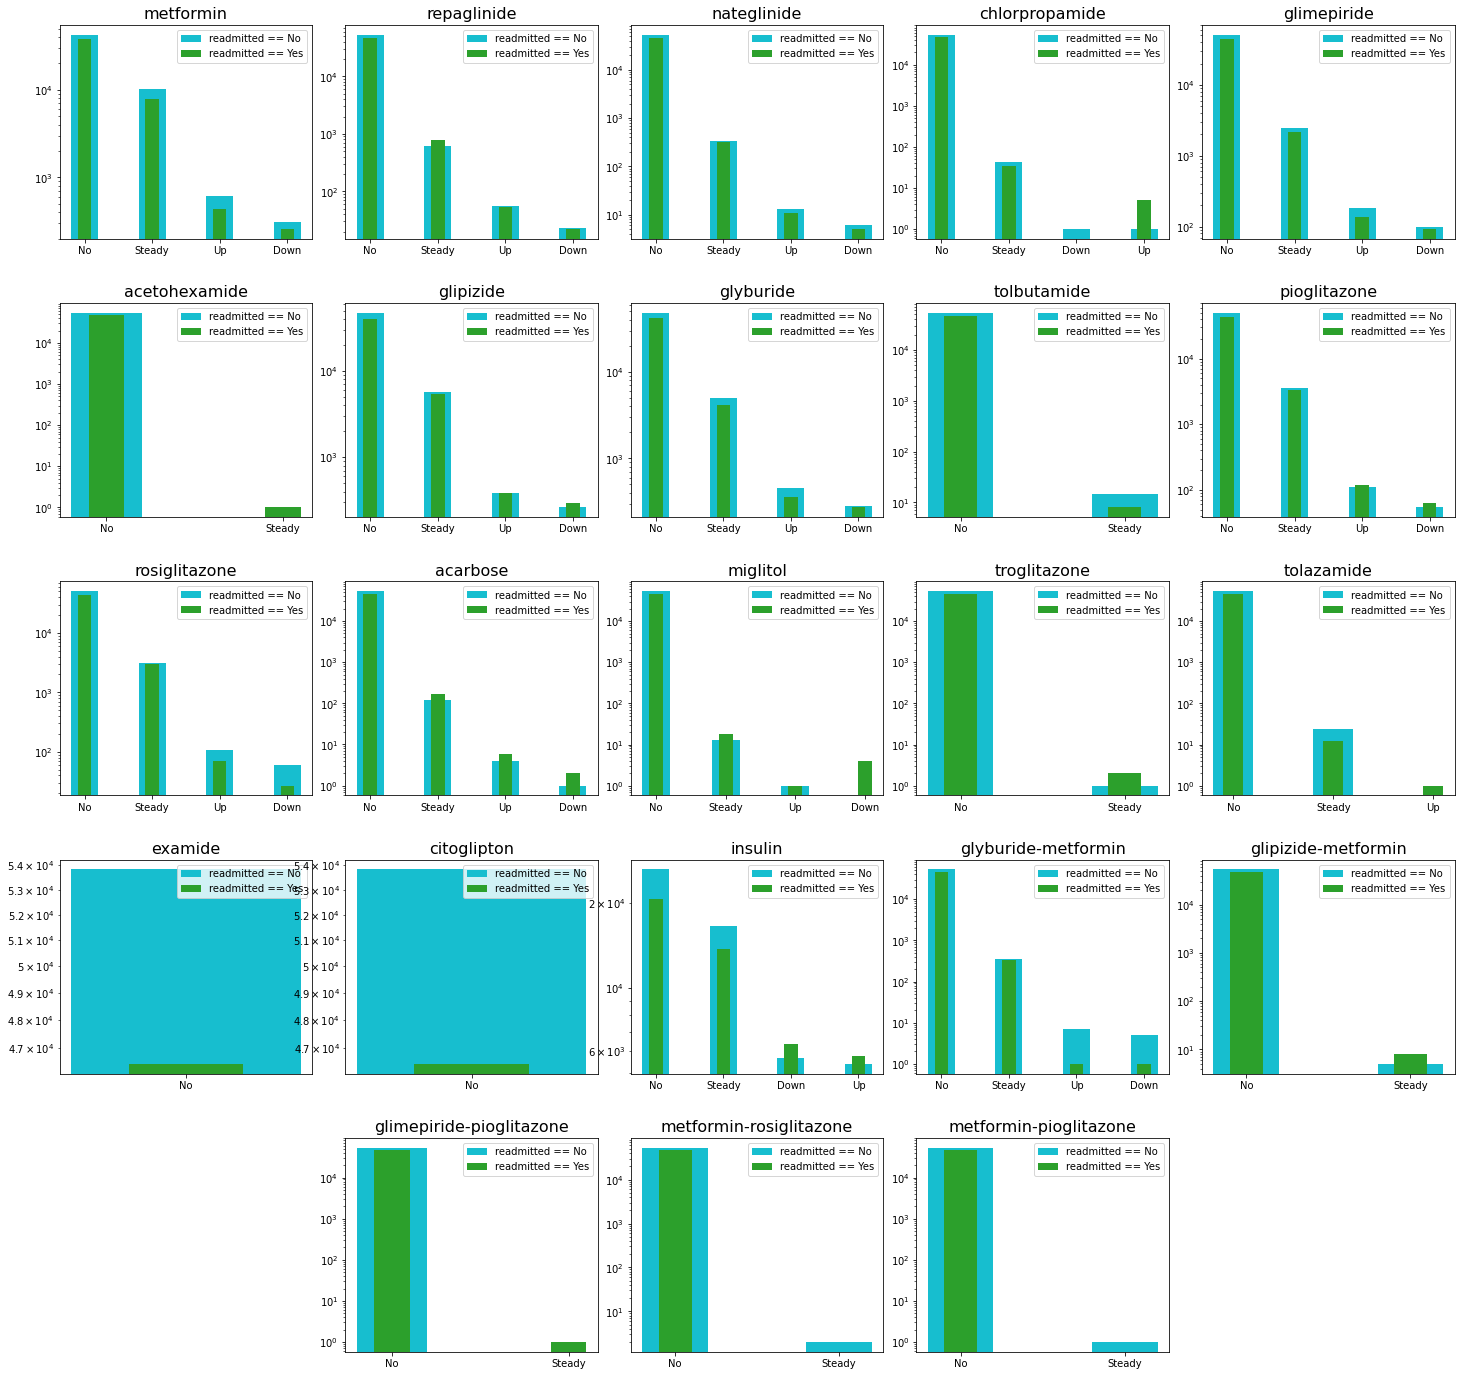

Wall time: 10.5 s


In [34]:
%%time

# Creo le 23 figure come subplot
fig = plt.figure(figsize = (25,50))
gs = gridspec.GridSpec(nrows = 10, ncols = 10, hspace = .3, wspace = .3)

ax = []
for r in range(4):
    for c in range(5):
        ax.append( fig.add_subplot(gs[r, (2*c):(2*c+2)]) )

ax.append( fig.add_subplot(gs[4, 2:4]) )
ax.append( fig.add_subplot(gs[4, 4:6]) )
ax.append( fig.add_subplot(gs[4, 6:8]) )


# Creo le 2 condizioni per verificare la remissione
cond_No = dati["readmitted_2"] == "No"
cond_Yes = dati["readmitted_2"] == "Yes"


# Plotto le 23 features
for graf,i in enumerate( lista_medicinali ):
    ax[graf].set_title(f"{i}", fontsize = 16)
    
    ax[graf].bar( dati[i][cond_No].value_counts().index, height = dati[i][cond_No].value_counts(), width = .4, color = "tab:cyan", label = "readmitted == No")
    ax[graf].bar( dati[i][cond_Yes].value_counts().index, height = dati[i][cond_Yes].value_counts(), width = .2, color = "tab:green", label = "readmitted == Yes")

    ax[graf].set_yscale("log")
    ax[graf].legend()

fig.savefig("../Esame_relazione/FIGURE/dataset/featuresVSreadmitted.pdf", format = "pdf", bbox_inches = "tight")

plt.show()

Le medicine "examide" e "citoglipton" non sono state mai prescritte ad alcun paziente e quindi elimino queste colonne dal DS.

Inoltre, anche i medicinali "acetohexamide", "tolbutamide", "troglitazone", "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone" e "metformin-pioglitazone" sono stati prescritti a pochissimi pazienti ed inoltre non portano informazioni aggiuntive sul fatto che un paziente si sia rimesso oppure no. Quindi non li considero ed elimino anche queste features

In [25]:
# Eliminazione della feature "examide"
dati.drop(columns = ["examide"], inplace = True)
# Eliminazione della feature "citoglipton"
dati.drop(columns = ["citoglipton"], inplace = True)
# Eliminazione della feature "acetohexamide"
dati.drop(columns = ["acetohexamide"], inplace = True)
# Eliminazione della feature "tolbutamide"
dati.drop(columns = ["tolbutamide"], inplace = True)
# Eliminazione della feature "troglitazone"
dati.drop(columns = ["troglitazone"], inplace = True)
# Eliminazione della feature "glipizide-metformin"
dati.drop(columns = ["glipizide-metformin"], inplace = True)
# Eliminazione della feature "glimepiride-pioglitazone"
dati.drop(columns = ["glimepiride-pioglitazone"], inplace = True)
# Eliminazione della feature "metformin-rosiglitazone"
dati.drop(columns = ["metformin-rosiglitazone"], inplace = True)
# Eliminazione della feature "metformin-pioglitazone"
dati.drop(columns = ["metformin-pioglitazone"], inplace = True)

dati.shape

(100241, 36)

---

### Ulteriori features

Dalla figura iniziale, rappresentante tutte le 47 features, osservo che ci sono delle features che non ho ancora commentato:
* age: rappresenta l'età del paziente ricoverato (numerico)
* admission_type_id: rappresenta in che reparto è stato curato il paziente (numerico)
* discharge_disposition_id: rappresenta il luogo di degenza del paziente dopo la dimissione. Per esempio: casa, ospizio, RSA... (numerico)
* admission_source_id: rappresenta il motivo per il quale il paziente è arrivato all'ospedale. Per esempio: emergenza, inviato da altro ospedale, ulteriore consulto... (numerico)
* time_in_hospital: rappresenta il numero di giorni trascorsi tra l'inizio del ricovero e le dimissioni del paziente (numerico)
* num_lab_procedures: rappresenta il numero di test di laboratorio eseguiti durante la degenza in ospedale (numerico)
* num_procedures: rappresenta il numero di esami eseguiti dal paziente durante la degenza in ospedale (numerico)
* num_medications: rappresenta il numero di medicazioni fatte al paziente (numerico)
* number_outpatient: rappresenta il numero di prestazioni ambulatoriali fatte dal paziente nell'anno precedente al ricovero (numerico)
* number_emergency: rappresenta il numero di ricoveri d'urgenza effettuati dal paziente nell'anno precedente al ricovero (numerico)
* number_inpatient: rappresenta il numero di ricoveri affettuati dal paziente nell'anno precedente al ricovero (numerico)
* number_diagnoses: rappresenta il numero di diagnosi ricevute dal paziente durante il ricovero (numerico)
* max_glu_serum: rappresenta il risultato del test "glucose serum". I possibili risultati sono: None, Norm, >200, >300
* A1Cresult: rappresenta il risultato del test "A1C". I possibili risultati sono: None, Norm, >7, >8
* change: indica se ci sono stati cambiamenti nelle medicazioni, sia di dosaggio sia di farmaco... I possibili risultati sono: Ch, No
* diabetesMed: indica se è stata prescritta una medicazione diabetica. I possibili risultati sono: Yes, No


In particolare tutte queste feature non hanno delle distribuzioni particolari o che richiedono un ulteriore analisi quindi le mantengo tutte nel DS

---

### Commenti finali

Sono partito da un dataset composto da 101766 eventi e 50 features. Dopo la prima parte di analisi ho eliminato 14 features perchè prive di informazioni utili alle analisi successive e 1525 eventi perchè nulli.

Quindi, alla fine, ho un dataset composto da 100241 eventi e 36 features.

In [26]:
print("Il dataset finale è composto da", dati.shape[0], "eventi e", dati.shape[1], "features")

Il dataset finale è composto da 100241 eventi e 36 features


---

---

# Data Scaling

Prima di procedere oltre, resetto gli indici del dataset visto che ho eliminato alcune features e alcuni eventi

Inoltre creo una copia del DS che utilizzerò da ora in poi

In [27]:
# Resetto gli indici
dati.reset_index(inplace = True, drop = True)
dati.head(5)

race  gender      age  admission_type_id  \
0        Caucasian  Female  [10-20)                  1   
1  AfricanAmerican  Female  [20-30)                  1   
2        Caucasian    Male  [30-40)                  1   
3        Caucasian    Male  [40-50)                  1   
4        Caucasian    Male  [50-60)                  2   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                         1                    7                 3   
1                         1                    7                 2   
2                         1                    7                 2   
3                         1                    7                 1   
4                         1                    2                 3   

   num_lab_procedures  num_procedures  num_medications  ...  pioglitazone  \
0                  59               0               18  ...            No   
1                  11               5               13  ...            No   
2                  44               1               16  ...            No   
3                  51               0                8  ...            No   
4                  31               6               16  ...            No   

   rosiglitazone  acarbose miglitol tolazamide insulin  glyburide-metformin  \
0             No        No       No         No      Up                   No   
1             No        No       No         No      No                   No   
2             No        No       No         No      Up                   No   
3             No        No       No         No  Steady                   No   
4             No        No       No         No  Steady                   No   

  change diabetesMed readmitted_2  
0     Ch         Yes          Yes  
1     No         Yes           No  
2     Ch         Yes           No  
3     Ch         Yes           No  
4     No         Yes          Yes  

[5 rows x 36 columns]

In [28]:
# Creo una copia del DS successiva al Data Processing che tengo di backup
dati_postDP = dati.copy()

A questo punto posso trasformare la rappresentazione letterale di alcune features con una rappresentazione numerica, più adatta ad essere compresa da un algoritmo

In [29]:
# Creo il modo di encodare i dati
le = LabelEncoder()

# Trasformo i dati letterali in numerici
for graf,i in enumerate( dati.columns ):
    if dati.dtypes[graf] != np.int64:
        dati[i] = le.fit_transform( dati[i] )

dati.head(5)

race  gender  age  admission_type_id  discharge_disposition_id  \
0     2       0    1                  1                         1   
1     0       0    2                  1                         1   
2     2       1    3                  1                         1   
3     2       1    4                  1                         1   
4     2       1    5                  2                         1   

   admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  \
0                    7                 3                  59               0   
1                    7                 2                  11               5   
2                    7                 2                  44               1   
3                    7                 1                  51               0   
4                    2                 3                  31               6   

   num_medications  ...  pioglitazone  rosiglitazone  acarbose  miglitol  \
0               18  ...             1              1         1         1   
1               13  ...             1              1         1         1   
2               16  ...             1              1         1         1   
3                8  ...             1              1         1         1   
4               16  ...             1              1         1         1   

   tolazamide  insulin  glyburide-metformin  change  diabetesMed  readmitted_2  
0           0        3                    1       0            1             1  
1           0        1                    1       1            1             0  
2           0        3                    1       0            1             0  
3           0        2                    1       0            1             0  
4           0        2                    1       1            1             1  

[5 rows x 36 columns]

Verifico come sono stati encodati i dati della colonna dei risultati "readmitted_2"

In [30]:
print(f"Il valore {dati_postDP['readmitted_2'][0]} è diventato {dati['readmitted_2'][0]}")
print(f"Il valore {dati_postDP['readmitted_2'][1]} è diventato {dati['readmitted_2'][1]}")

Il valore Yes è diventato 1
Il valore No è diventato 0


---

### Salvataggio dei dati

In [31]:
# Salvo i valori delle features nel vettore delle X
X = dati.iloc[:,:-1].values

# Salvo i valori delle classi nel vettore delle y
y = dati.iloc[:,-1:].values.flatten()

# Salvo i valori delle label features
features = dati.columns[:-1]

print(X.shape)
print(y.shape)
print(features.shape)

(100241, 35)
(100241,)
(35,)


A questo punto, dopo aver esplorato il DS, aver rimosso tutti i casi patologici ed aver encodato i valori delle features letterari in numeri, posso esportare i dati che saranno quelli che andrò ad utilizzare nelle varie analisi

In [32]:
np.savez("dataSet/dati_finali.npz", X = X, y = y, features = features)

---

### Grandezze statistiche
Visualizzo alcuni indicatori statistici per verificare alcune grandezze associate a ciascuna feature

In [33]:
print(f"Feature                   \t| Min  \t| Max \t| Range | Mean  \t| Std \t\t| Unique Val")
print(f"------------------------- \t| ---  \t| --- \t| ----- | ----  \t| --- \t\t| ----------")

for i in range(X.shape[1]):
    print(f"{features[i].ljust(26)}\t| {X[:,i].min():d} \t| {X[:,i].max():d} \t| {X[:,i].max() - X[:,i].min() + 1:d} \t| {X[:,i].mean():.2f}  \t| {X[:,i].std():.2f}  \t| {len(np.unique(X[:,i]))} ")


Feature                   	| Min  	| Max 	| Range | Mean  	| Std 		| Unique Val
------------------------- 	| ---  	| --- 	| ----- | ----  	| --- 		| ----------
race                      	| 0 	| 4 	| 5 	| 1.71  	| 0.92  	| 5 
gender                    	| 0 	| 1 	| 2 	| 0.46  	| 0.50  	| 2 
age                       	| 0 	| 9 	| 10 	| 6.13  	| 1.56  	| 10 
admission_type_id         	| 1 	| 8 	| 8 	| 2.02  	| 1.44  	| 8 
discharge_disposition_id  	| 1 	| 28 	| 28 	| 3.73  	| 5.28  	| 26 
admission_source_id       	| 1 	| 25 	| 25 	| 5.76  	| 4.06  	| 17 
time_in_hospital          	| 1 	| 14 	| 14 	| 4.42  	| 2.99  	| 14 
num_lab_procedures        	| 1 	| 132 	| 132 	| 43.17  	| 19.69  	| 118 
num_procedures            	| 0 	| 6 	| 7 	| 1.35  	| 1.71  	| 7 
num_medications           	| 1 	| 81 	| 81 	| 16.12  	| 8.12  	| 75 
number_outpatient         	| 0 	| 42 	| 43 	| 0.37  	| 1.27  	| 39 
number_emergency          	| 0 	| 76 	| 77 	| 0.20  	| 0.93  	| 33 
number_inpatient          	| 0 

---

### Scaling
Dalla tabella precedente osservo che ho delle grandezze che variano su scale differenti. Pertanto è necessario procedere con una normalizzazione dei dati

Ho a disposizione diversi metodi per scalare i dati (vedi pacchetto [preprocessing di sklearn](https://scikit-learn.org/stable/modules/preprocessing.htm)), li provo tutti e scelgo quello che ritengo il migliore

In [34]:
# Uso lo scaler Minimo-Massimo: valore * (max - min) + min
X_minmax = preprocessing.MinMaxScaler().fit_transform(X)

# Uso lo scaler Massimo in modulo: scalo il valore per il suo valore massimo in modulo
X_maxabs = preprocessing.MaxAbsScaler().fit_transform(X)

# Uso lo scaler Standard: (valore - media) / std
X_normal = preprocessing.StandardScaler().fit_transform(X)

# Uso lo scaler Robusto: robusto per eventuali outliers
X_robust = preprocessing.RobustScaler().fit_transform(X)

In [36]:
%%time

# Creo le 35 figure delle features come subplot
fig = plt.figure(figsize = (25,50))
gs = gridspec.GridSpec(nrows = 7, ncols = 10, hspace = .3, wspace = .3)

ax = []
for r in range(7):
    for c in range(5):
        ax.append( fig.add_subplot(gs[r, (2*c):(2*c+2)]) )


# Plotto le 35 features
for i in range( X.shape[1] ):
    ax[i].set_title(f"Feature: {features[i]}", fontsize = 16)
    
    # MinMaxScaler 
    h, bins = np.histogram(X_minmax[:,i], bins = 10)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax[i].plot(binc, h, ds = "steps-mid", c = "tab:cyan", label = "MinMaxScaler")
    
#     # MaxAbsScaler 
#     h, bins = np.histogram(X_maxabs[:,i], bins = 20)
#     binc = bins[:-1] + (bins[1] - bins[0])/2
#     ax[i].plot(binc, h, ds = "steps-mid", c = "tab:red", label = "MaxAbsScaler")    
    
#     # StandardScaler 
#     h, bins = np.histogram(X_normal[:,i], bins = 20)
#     binc = bins[:-1] + (bins[1] - bins[0])/2
#     ax[i].plot(binc, h, ds = "steps-mid", c = "tab:green", label = "StandardScaler")
    
#     # RobustScaler 
#     h, bins = np.histogram(X_robust[:,i], bins = 20)
#     binc = bins[:-1] + (bins[1] - bins[0])/2
#     ax[i].plot(binc, h, ds = "steps-mid", c = "tab:gray", label = "RobustScaler")
    
    ax[i].set_yscale("log")
    ax[i].legend()

# Per salvare la figura con solo lo MinMaxScaler
fig.savefig("../Esame_relazione/FIGURE/dataset/featuresVSMinMax.pdf", format = "pdf", bbox_inches = "tight")
# Per salvare la figura con tutti gli Scaler a disposizione
# fig.savefig("../Esame_relazione/FIGURE/dataset/featuresVSscaler.pdf", format = "pdf", bbox_inches = "tight")

plt.show()

Wall time: 32.4 s


Per la natura delle feature che ho nel mio DS, lo scaler [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) è la migliore scelta perchè le features che ho trasformato da parole a numeri non hanno una distribuzione, ma sono dei valori discreti ed inoltre hanno poca variabilità (variano in un range massimo di 4 possibili valori)

Visualizzo gli stessi indicatori statistici per verificare che le grandezze associate a ciascuna feature varino negli stessi intervalli

In [ ]:
print(f"Feature                   \t| Min  \t| Max \t| Range | Mean  | Std \t| Unique Val")
print(f"------------------------- \t| ---  \t| --- \t| ----- | ----  | --- \t| ----------")

for i in range(X.shape[1]):
    print(f"{features[i].ljust(26)}\t| {X_minmax[:,i].min():.1f} \t| {X_minmax[:,i].max():.1f} \t| {X_minmax[:,i].max() - X_minmax[:,i].min() + 1:.1f} \t| {X_minmax[:,i].mean():.2f}  | {X_minmax[:,i].std():.2f}  | {len(np.unique(X_minmax[:,i]))} ")


Feature                   	| Min  	| Max 	| Range | Mean  | Std 	| Unique Val
------------------------- 	| ---  	| --- 	| ----- | ----  | --- 	| ----------
race                      	| 0.0 	| 1.0 	| 2.0 	| 0.43  | 0.23  | 5 
gender                    	| 0.0 	| 1.0 	| 2.0 	| 0.46  | 0.50  | 2 
age                       	| 0.0 	| 1.0 	| 2.0 	| 0.68  | 0.17  | 10 
admission_type_id         	| 0.0 	| 1.0 	| 2.0 	| 0.15  | 0.21  | 8 
discharge_disposition_id  	| 0.0 	| 1.0 	| 2.0 	| 0.10  | 0.20  | 26 
admission_source_id       	| 0.0 	| 1.0 	| 2.0 	| 0.20  | 0.17  | 17 
time_in_hospital          	| 0.0 	| 1.0 	| 2.0 	| 0.26  | 0.23  | 14 
num_lab_procedures        	| 0.0 	| 1.0 	| 2.0 	| 0.32  | 0.15  | 118 
num_procedures            	| 0.0 	| 1.0 	| 2.0 	| 0.23  | 0.29  | 7 
num_medications           	| 0.0 	| 1.0 	| 2.0 	| 0.19  | 0.10  | 75 
number_outpatient         	| 0.0 	| 1.0 	| 2.0 	| 0.01  | 0.03  | 39 
number_emergency          	| 0.0 	| 1.0 	| 2.0 	| 0.00  | 0.01  | 33 
number_

---

## Principal Componet Analysis (PCA)

In [38]:
# Calcolo la matrice di covarianza
myCov = np.cov(X_minmax, rowvar = False)

# Plotto
fig, ax = plt.subplots(figsize = (23,21))
ax.set_title(f"Matrice di covarianza sui dati riscalati: X_minmax", fontsize = 16)

# Plotto la matrice di covarianza
im = ax.imshow(myCov, cmap = "jet", origin = "upper")

# Stampo i valori sulle celle
for i in range( myCov.shape[0] ):
    for j in range( myCov.shape[1] ):
        text = ax.text(j, i, f"{myCov[i, j]:.2f}", ha = "center", va = "center", color = "white")

# Disegno la colorbar
fig.colorbar(im)

fig.savefig("../Esame_relazione/FIGURE/dataset/PCA.pdf", format = "pdf", bbox_inches = "tight")

plt.show()

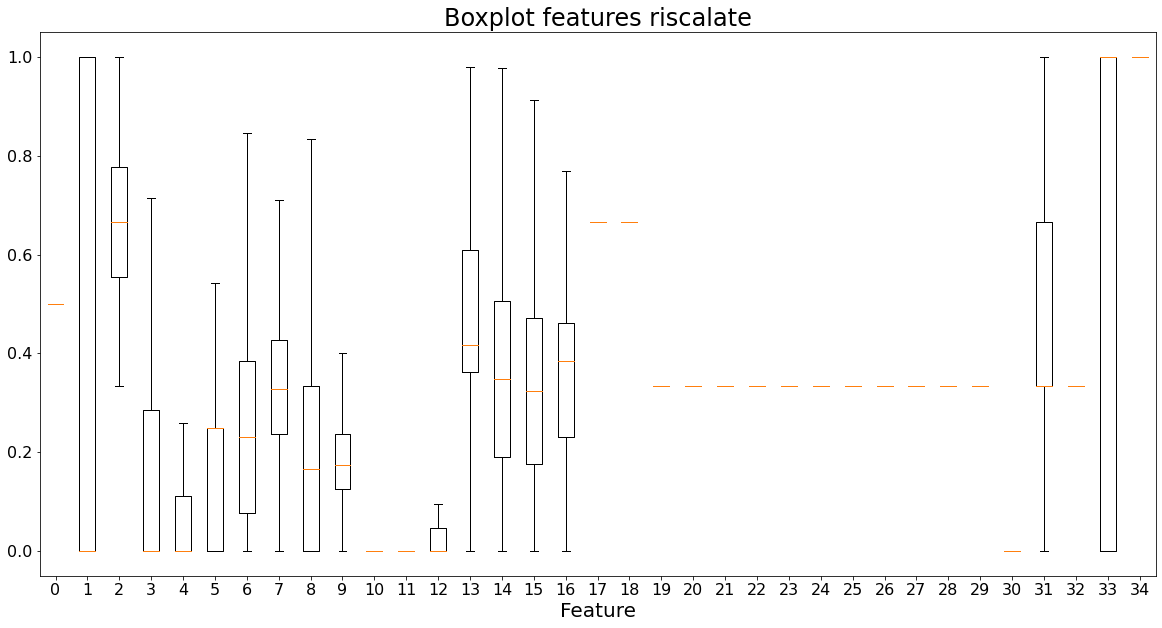

In [39]:
# Disegno il boxplot delle features riscalate con il MinMax
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.set_title("Boxplot features riscalate", fontsize = 24)

ax.boxplot(X_minmax, showfliers = False)

ax.set_xlabel("Feature", fontsize = 20)
ax.tick_params(axis = "both", which = "major", labelsize = 16)
ax.set_xticklabels(ax.get_xticks()-1 )

fig.savefig("../Esame_relazione/FIGURE/dataset/boxplot.pdf", format = "pdf", bbox_inches = "tight")

plt.show()

In [40]:
# Applico la PCA
pca = decomposition.PCA()
pca.fit(X_minmax)

# Estraggo le Explained Variances e le Explained Variances cumulativa
X_ev = pca.explained_variance_ratio_
X_cumev = np.cumsum(X_ev)

print(f"Ho bisogno di {np.sum(X_cumev < .9)} features su {X_minmax.shape[1]} per arrivare alla soglia del 90 %")
print(f"Ho bisogno di {np.sum(X_cumev < .95)} features su {X_minmax.shape[1]} per arrivare alla soglia del 95 %")
print(f"Ho bisogno di {np.sum(X_cumev < .98)} features su {X_minmax.shape[1]} per arrivare alla soglia del 98 %")
print(f"Ho bisogno di {np.sum(X_cumev < .99)} features su {X_minmax.shape[1]} per arrivare alla soglia del 99 %")

Ho bisogno di 14 features su 35 per arrivare alla soglia del 90 %
Ho bisogno di 18 features su 35 per arrivare alla soglia del 95 %
Ho bisogno di 21 features su 35 per arrivare alla soglia del 98 %
Ho bisogno di 24 features su 35 per arrivare alla soglia del 99 %


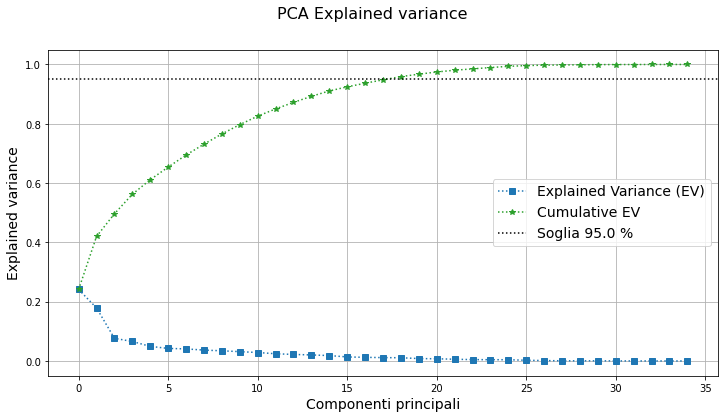

In [44]:
soglia = .95

fig, ax = plt.subplots(figsize = (12,6))
fig.suptitle("PCA Explained variance", fontsize = 16)

ax.plot(X_ev, ls = ":", marker = "s", label = "Explained Variance (EV)", c = "tab:blue")
ax.plot(X_cumev, ls = ":", marker = "*", label  = "Cumulative EV", c = "tab:green")

ax.axhline(y = soglia, ls = ":", c = "k", label = f"Soglia {soglia*100} %")

ax.set_xlabel("Componenti principali", fontsize = 14)
ax.set_ylabel("Explained variance", fontsize = 14)

ax.grid()
ax.legend(fontsize = 14)
plt.show()